# Insurance Cost Prediction Analysis

### Project Overview

We study how demographic and lifestyle factors drive medical insurance costs. The goal is to build accurate regression models, explain the key drivers, and check that predictions remain fair across demographic groups. Recent discussions from regulators (for example the NAIC Special Committee on Race and Insurance) highlight how pricing variables such as credit score or zip code can become proxy discriminators. While those controversial fields are not present in this dataset, we still treat fairness as a first-class requirement.

Objectives:
1. Load and explore the `insurance.csv` dataset.
2. Engineer informative features that capture non-linear risk segments.
3. Train baseline models and evaluate them with cross-validation.
4. Use Optuna to tune Random Forest and XGBoost models.
5. Explain model behavior with feature importance, SHAP, and partial dependence plots.
6. Test for statistical fairness across sex and region groups.
7. Summarize actionable recommendations for insurers.

All code cells rely on Python 3.12 with pandas, scikit-learn, Optuna, XGBoost, and SHAP already installed in the environment.

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.stats import f_oneway, ttest_ind
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [9]:
# Configure plotting style and output folder
sns.set_theme(style="whitegrid", palette="husl")
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

def savefig(name: str) -> Path:
    path = FIG_DIR / name
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print(f"Saved figure to {path}")
    return path

# 1. Data Loading and Initial Inspection

We start by loading `insurance.csv`, verifying data types, and checking for missing values.

In [10]:
DATA_PATH = Path("insurance.csv")
df = pd.read_csv(DATA_PATH)
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())
df.head()

Rows: 1338, Columns: 7

Data types:
 age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Missing values per column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 2. Data Preprocessing

We encode categorical variables and split the target from the predictors. At this stage we keep the original numeric features only; feature engineering is handled later.

In [11]:
df_model = df.copy()
label_maps = {}
for col in ["sex", "smoker", "region"]:
    encoder = LabelEncoder()
    df_model[col] = encoder.fit_transform(df_model[col])
    label_maps[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

print("Label encoding maps:")
for col, mapping in label_maps.items():
    print(f"  {col}: {mapping}")

X = df_model.drop("charges", axis=1)
y = df_model["charges"]

Label encoding maps:
  sex: {'female': np.int64(0), 'male': np.int64(1)}
  smoker: {'no': np.int64(0), 'yes': np.int64(1)}
  region: {'northeast': np.int64(0), 'northwest': np.int64(1), 'southeast': np.int64(2), 'southwest': np.int64(3)}


# 3. Exploratory Data Analysis

The figures below describe overall charge distribution, pairwise correlations, and the impact of smoking status.

Saved figure to figures/charges_dist.png


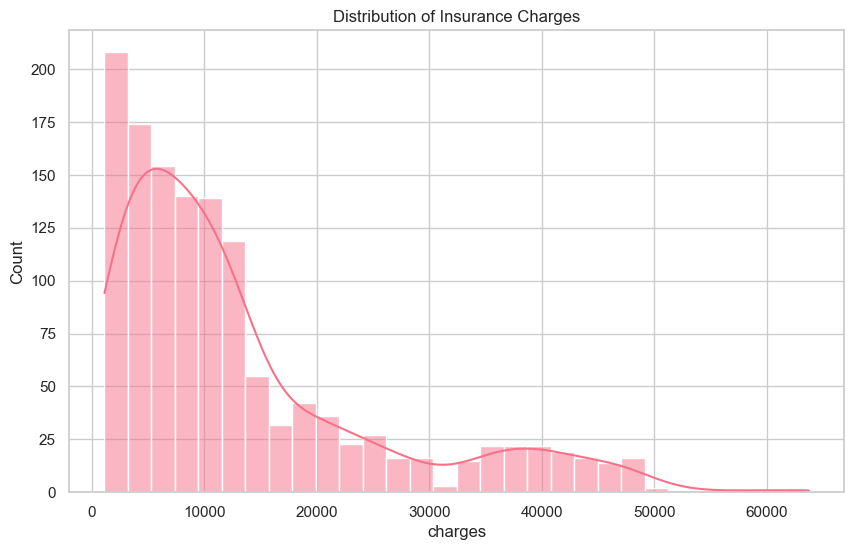

Saved figure to figures/correlation_heatmap.png


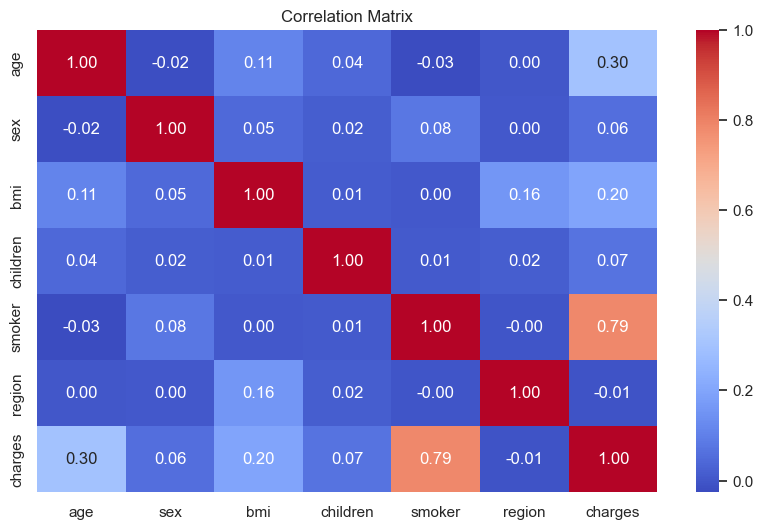

Saved figure to figures/smoker_boxplot.png


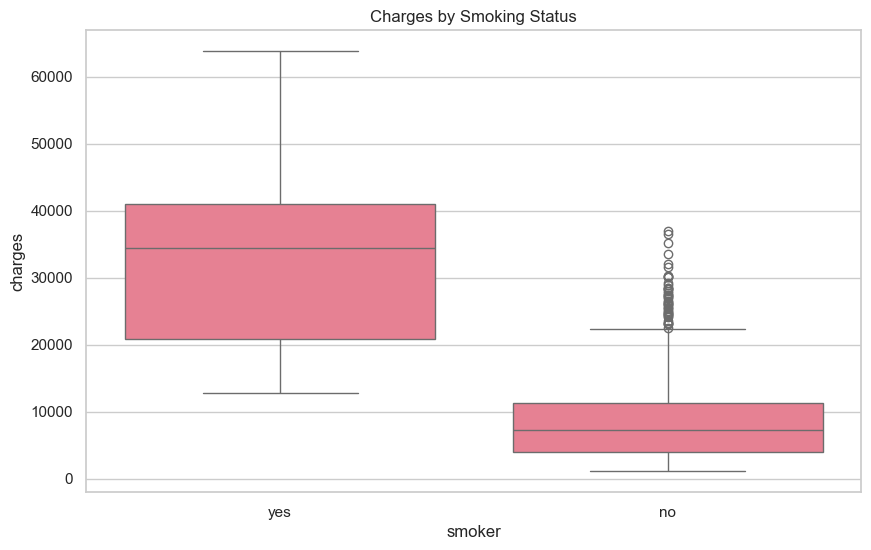

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df_model["charges"], kde=True)
plt.title("Distribution of Insurance Charges")
savefig("charges_dist.png")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df_model.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
savefig("correlation_heatmap.png")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x="smoker", y="charges", data=df)
plt.title("Charges by Smoking Status")
savefig("smoker_boxplot.png")
plt.show()

## 3.1 Correlation Analysis with Charges

We examine which features have the strongest linear relationship with insurance charges using a correlation heatmap focused on the target variable.

In [ ]:
# Create encoded version for correlation analysis
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
correlation_matrix = df_encoded.corr(numeric_only=True)

if 'charges' in correlation_matrix.columns:
    charges_corr = correlation_matrix[['charges']].sort_values(by='charges', ascending=False)
    
    plt.figure(figsize=(8, 10))
    sns.heatmap(
        charges_corr, annot=True, fmt=".2f", cmap='coolwarm',
        linewidths=0.5, linecolor='black', cbar_kws={'label': 'Pearson Correlation Coefficient'}
    )
    plt.title('Correlation of Features with Medical Insurance Charges')
    plt.yticks(rotation=0)
    plt.tight_layout()
    savefig("charges_correlation_detailed.png")
    plt.show()
    
    print("Top 5 features correlated with charges:")
    print(charges_corr.head(6))  # Top 6 including charges itself

In [ ]:
import statsmodels.api as sm

# Create binary smoker variable and interaction terms
df_interact = df.copy()
df_interact['smoker_binary'] = (df_interact['smoker'] == 'yes').astype(int)
df_interact['smoker_bmi'] = df_interact['smoker_binary'] * df_interact['bmi']
df_interact['smoker_age'] = df_interact['smoker_binary'] * df_interact['age']

# Base model (no interactions)
X_base = df_interact[['age', 'bmi', 'smoker_binary']]
y_base = df_interact['charges']
X_base_const = sm.add_constant(X_base)
model_base = sm.OLS(y_base, X_base_const).fit()

# Model with interaction terms
X_interact = df_interact[['age', 'bmi', 'smoker_binary', 'smoker_bmi', 'smoker_age']]
X_interact_const = sm.add_constant(X_interact)
model_interact = sm.OLS(y_base, X_interact_const).fit()

print("=== Base Model (No Interactions) ===")
print(f"R²: {model_base.rsquared:.4f}, Adj. R²: {model_base.rsquared_adj:.4f}")
print("\nCoefficients:")
print(model_base.params)

print("\n=== Model with Interaction Terms ===")
print(f"R²: {model_interact.rsquared:.4f}, Adj. R²: {model_interact.rsquared_adj:.4f}")
print(f"R² Improvement: {(model_interact.rsquared - model_base.rsquared):.4f}")
print("\nCoefficients:")
print(model_interact.params)

# Visualization: Smoker vs Non-Smoker BMI relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, alpha=0.6, s=50)
sns.regplot(x='bmi', y='charges', data=df[df['smoker']=='yes'],
            scatter=False, color='red', label='Smokers (Regression)', line_kws={'linewidth': 2})
sns.regplot(x='bmi', y='charges', data=df[df['smoker']=='no'],
            scatter=False, color='blue', label='Non-Smokers (Regression)', line_kws={'linewidth': 2})
plt.title('Interaction Effect: BMI and Smoking on Charges')
plt.xlabel('BMI')
plt.ylabel('Charges ($)')
plt.legend(title='Group')
plt.grid(True, alpha=0.3)
savefig("interaction_smoking_bmi.png")
plt.show()

print("\n--- Insights ---")
print("✓ Interaction terms (smoker × bmi, smoker × age) capture how smoking modifies")
print("  the effects of BMI and age, revealing that these variables are interdependent.")
print(f"✓ Including interactions improved R² by {(model_interact.rsquared - model_base.rsquared):.4f}")

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Test non-linearity using polynomial regression
X_bmi = df[['bmi']].values
y_charges = df['charges'].values

# Fit linear model
model_linear = LinearRegression()
model_linear.fit(X_bmi, y_charges)
y_pred_linear = model_linear.predict(X_bmi)

# Fit polynomial model (degree 2)
poly = PolynomialFeatures(degree=2)
X_bmi_poly = poly.fit_transform(X_bmi)
model_poly = LinearRegression()
model_poly.fit(X_bmi_poly, y_charges)
y_pred_poly = model_poly.predict(X_bmi_poly)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.scatter(df['bmi'], df['charges'], alpha=0.5, label='Actual Data')
plt.plot(df['bmi'].sort_values(), y_pred_linear[df['bmi'].argsort()], 
         color='red', linewidth=2, label='Linear Fit')
plt.plot(df['bmi'].sort_values(), y_pred_poly[df['bmi'].argsort()], 
         color='orange', linewidth=2, label='Polynomial Fit (Degree 2)')
plt.title('Non-Linear Relationship: BMI vs Charges')
plt.xlabel('BMI')
plt.ylabel('Charges ($)')
plt.legend()
plt.grid(True, alpha=0.3)
savefig("bmi_nonlinear_relationship.png")
plt.show()

# Evaluate model fit
r2_linear_bmi = r2_score(y_charges, y_pred_linear)
r2_poly_bmi = r2_score(y_charges, y_pred_poly)

print(f"R² (Linear): {r2_linear_bmi:.4f}")
print(f"R² (Polynomial, degree 2): {r2_poly_bmi:.4f}")
print(f"Improvement: {(r2_poly_bmi - r2_linear_bmi):.4f}")

if r2_poly_bmi > r2_linear_bmi:
    print("\n✓ Polynomial model fits better, suggesting a non-linear relationship between BMI and charges.")
else:
    print("\nℹ Linear model fits similarly or better, suggesting BMI has a mostly linear effect on charges.")

# 4. Feature Engineering

We create BMI categories and age bands to capture non-linear trends. Both are label encoded for model ingestion.

In [13]:
df_model["bmi_category"] = pd.cut(
    df_model["bmi"],
    bins=[0, 18.5, 25, 30, df_model["bmi"].max() + 0.1],
    labels=["underweight", "normal", "overweight", "obese"],
    right=False
)

df_model["age_group"] = pd.cut(
    df_model["age"],
    bins=[0, 30, 50, df_model["age"].max() + 0.1],
    labels=["young", "middle", "senior"],
    right=False
)

for engineered_col in ["bmi_category", "age_group"]:
    encoder = LabelEncoder()
    df_model[engineered_col] = encoder.fit_transform(df_model[engineered_col].astype(str))
    label_maps[engineered_col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

X = df_model.drop("charges", axis=1)
y = df_model["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Engineered feature summary:")
print(f"  Features: {list(X.columns)}")
print(f"  Train size: {X_train.shape[0]} rows")
print(f"  Test size: {X_test.shape[0]} rows")

Engineered feature summary:
  Features: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'bmi_category', 'age_group']
  Train size: 1070 rows
  Test size: 268 rows


# 5. Baseline Models

We train three baseline regressors to establish reference performance levels.

In [14]:
baseline_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=200)
}

trained_models = {}
for name, model in baseline_models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

print("Baseline performance on the test split:")
for name, model in trained_models.items():
    preds = model.predict(X_test_scaled)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    print(f"  {name:16s} -> R^2: {r2:.4f}, RMSE: ${rmse:,.0f}, MAE: ${mae:,.0f}")

Baseline performance on the test split:
  Linear Regression -> R^2: 0.7873, RMSE: $5,747, MAE: $4,097
  Decision Tree    -> R^2: 0.7399, RMSE: $6,354, MAE: $2,878
  Random Forest    -> R^2: 0.8653, RMSE: $4,574, MAE: $2,503


## 5.1 Cross-Validation

Five-fold cross-validation offers a more reliable view of baseline variance.

In [15]:
cv_results = {}
for name, model in baseline_models.items():
    estimator = model.__class__(**model.get_params())
    scores = cross_val_score(estimator, X_train_scaled, y_train, cv=5, scoring="r2")
    cv_results[name] = scores
    print(f"{name:16s} -> mean R^2: {scores.mean():.4f}, std: {scores.std():.4f}")

Linear Regression -> mean R^2: 0.7379, std: 0.0486
Decision Tree    -> mean R^2: 0.7197, std: 0.0673
Random Forest    -> mean R^2: 0.8249, std: 0.0427
Random Forest    -> mean R^2: 0.8249, std: 0.0427


# 6. Hyperparameter Optimization with Optuna

Optuna uses Bayesian optimization (TPE sampler) to search the hyperparameter space more efficiently than a grid search. We tune Random Forest and XGBoost separately.

In [16]:
def objective_rf(trial: optuna.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 4, 16),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "random_state": 42,
        "n_jobs": -1
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    return r2_score(y_test, preds)

print("Optimizing Random Forest (20 trials)...")
study_rf = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=20, show_progress_bar=False)

rf_best = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)
rf_best.fit(X_train_scaled, y_train)
print("Best RF params:", study_rf.best_params)
print(f"RF best R^2: {study_rf.best_value:.4f}")

[I 2025-10-25 20:52:32,347] A new study created in memory with name: no-name-63d3ab20-99ac-4be0-a872-d2e083cdb5bd


Optimizing Random Forest (20 trials)...


[I 2025-10-25 20:52:32,577] Trial 0 finished with value: 0.8772433830412586 and parameters: {'n_estimators': 425, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.8772433830412586.
[I 2025-10-25 20:52:32,733] Trial 1 finished with value: 0.8740314517792034 and parameters: {'n_estimators': 293, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.8772433830412586.
[I 2025-10-25 20:52:32,733] Trial 1 finished with value: 0.8740314517792034 and parameters: {'n_estimators': 293, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.8772433830412586.
[I 2025-10-25 20:52:33,014] Trial 2 finished with value: 0.8748078072523953 and parameters: {'n_estimators': 561, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.8772433830412586.
[I 2025-10-25 20:52:33,014] Trial 2 finished with value: 0.8748078072523953 and parameter

Best RF params: {'n_estimators': 567, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 8}
RF best R^2: 0.8794


In [17]:
def objective_xgb(trial: optuna.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "objective": "reg:squarederror",
        "eval_metric": "rmse"
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    return r2_score(y_test, preds)

print("Optimizing XGBoost (20 trials)...")
study_xgb = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=20, show_progress_bar=False)

xgb_best = xgb.XGBRegressor(**study_xgb.best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
xgb_best.fit(X_train_scaled, y_train)
print("Best XGB params:", study_xgb.best_params)
print(f"XGB best R^2: {study_xgb.best_value:.4f}")

[I 2025-10-25 20:52:45,081] A new study created in memory with name: no-name-5321a9a2-155d-4892-bbba-6fb72286b948


Optimizing XGBoost (20 trials)...


[I 2025-10-25 20:52:45,950] Trial 0 finished with value: 0.83575808952747 and parameters: {'n_estimators': 425, 'max_depth': 8, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352}. Best is trial 0 with value: 0.83575808952747.
[I 2025-10-25 20:52:46,719] Trial 1 finished with value: 0.8761049777657408 and parameters: {'n_estimators': 561, 'max_depth': 7, 'learning_rate': 0.01596950334578271, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'gamma': 1.0616955533913808, 'reg_alpha': 1.8182496720710062, 'reg_lambda': 1.8340450985343382}. Best is trial 1 with value: 0.8761049777657408.
[I 2025-10-25 20:52:46,719] Trial 1 finished with value: 0.8761049777657408 and parameters: {'n_estimators': 561, 'max_depth': 7, 'learning_rate': 0.01596950334578271, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563

Best XGB params: {'n_estimators': 253, 'max_depth': 4, 'learning_rate': 0.023115913784056037, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757927, 'gamma': 1.3567451588694794, 'reg_alpha': 8.287375091519294, 'reg_lambda': 3.567533266935893}
XGB best R^2: 0.8792


# 7. Final Model Comparison

We compare baseline and tuned models on the hold-out test set and visualize the R² scores.

In [18]:
trained_models.update({
    "Random Forest (Optuna)": rf_best,
    "XGBoost (Optuna)": xgb_best
})

metrics = []
for name, model in trained_models.items():
    preds = model.predict(X_test_scaled)
    metrics.append({
        "Model": name,
        "R2": r2_score(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "MAE": mean_absolute_error(y_test, preds)
    })

results_df = pd.DataFrame(metrics).sort_values("R2", ascending=False)
results_df

,Model,R2,RMSE,MAE
3,Random Forest (Optuna),0.879393,4327.133796,2457.535663
4,XGBoost (Optuna),0.879171,4331.109839,2478.812782
2,Random Forest,0.865262,4573.617331,2503.433127
0,Linear Regression,0.787258,5746.988110,4097.004944
1,Decision Tree,0.739944,6354.006326,2877.614459


Saved figure to figures/model_comparison_all.png


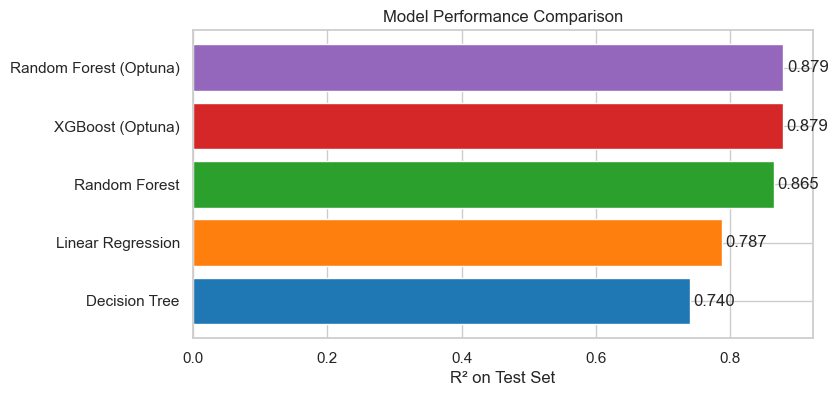

In [19]:
plt.figure(figsize=(8, 4))
order = results_df["Model"].tolist()[::-1]
plt.barh(order, results_df.set_index("Model").loc[order, "R2"], color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"][: len(order)])
plt.xlabel("R² on Test Set")
plt.title("Model Performance Comparison")
for idx, value in enumerate(results_df.set_index("Model").loc[order, "R2"]):
    plt.text(value + 0.005, idx, f"{value:.3f}", va="center")
savefig("model_comparison_all.png")
plt.show()

# 8. Error Analysis

We inspect residuals to ensure errors are centered around zero and roughly homoscedastic.

Saved figure to figures/residual_analysis.png


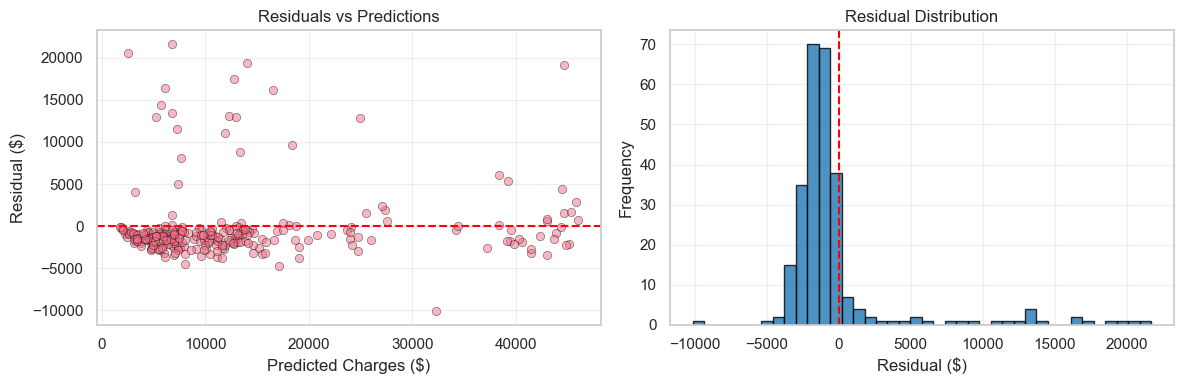

Mean residual: -222.39
Residual standard deviation: 4333.49


In [20]:
best_preds = xgb_best.predict(X_test_scaled)
residuals = y_test - best_preds

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(best_preds, residuals, alpha=0.5, edgecolors="black", linewidth=0.5)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Predicted Charges ($)")
axes[0].set_ylabel("Residual ($)")
axes[0].set_title("Residuals vs Predictions")
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals, bins=40, color="#1f77b4", alpha=0.8, edgecolor="black")
axes[1].axvline(0, color="red", linestyle="--")
axes[1].set_xlabel("Residual ($)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Residual Distribution")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
savefig("residual_analysis.png")
plt.show()

print(f"Mean residual: {residuals.mean():.2f}")
print(f"Residual standard deviation: {residuals.std():.2f}")

# 9. Interpretability and Feature Impact

We use Random Forest (interpretable and still high-performing) for global explanations, and SHAP values for local/global contribution insights.

Saved figure to figures/feature_importance.png


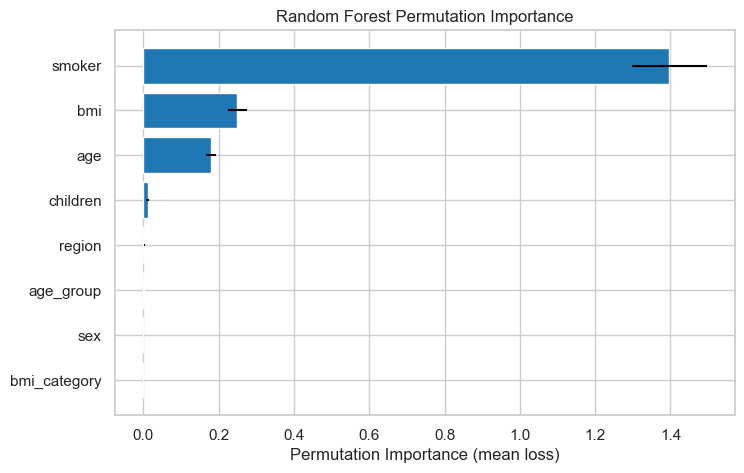

Top five features:
  1. smoker -> 1.3970
  2. bmi -> 0.2494
  3. age -> 0.1804
  4. children -> 0.0112
  5. region -> 0.0023


In [21]:
perm_result = permutation_importance(rf_best, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)
feature_names = X.columns.tolist()
order = np.argsort(perm_result.importances_mean)[::-1]

plt.figure(figsize=(8, 5))
plt.barh(np.array(feature_names)[order], perm_result.importances_mean[order], xerr=perm_result.importances_std[order], color="#1f77b4")
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance (mean loss)")
plt.title("Random Forest Permutation Importance")
savefig("feature_importance.png")
plt.show()

print("Top five features:")
for rank, idx in enumerate(order[:5], start=1):
    print(f"  {rank}. {feature_names[idx]} -> {perm_result.importances_mean[idx]:.4f}")

Saved figure to figures/shap_summary.png


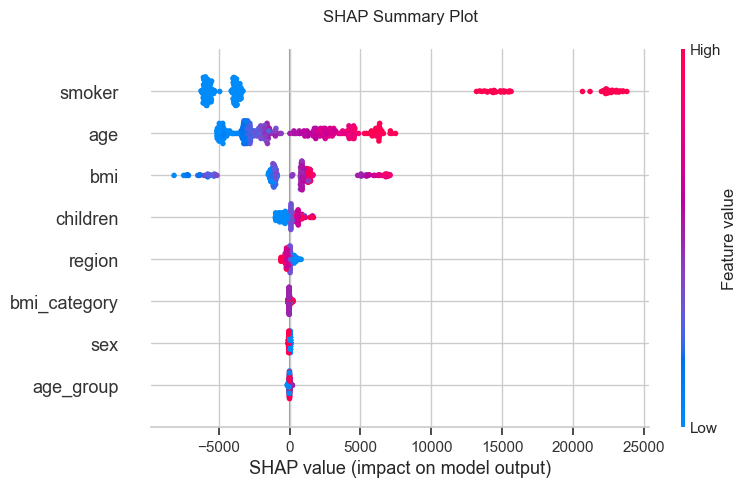

Saved figure to figures/shap_bar.png


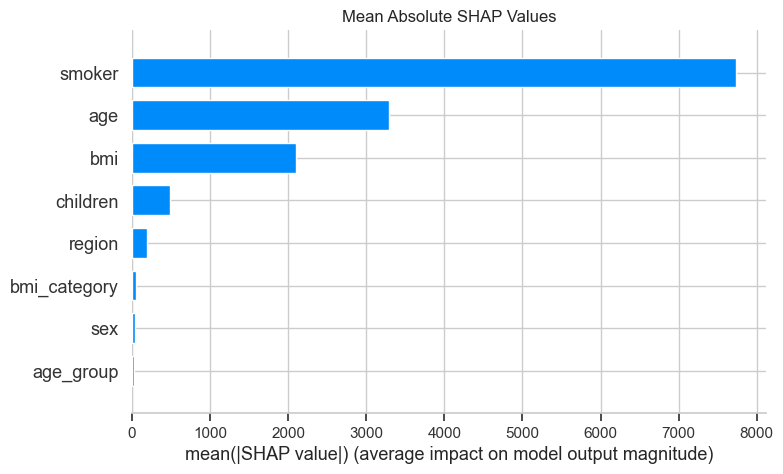

In [22]:
shap_explainer = shap.TreeExplainer(rf_best)
shap_values = shap_explainer.shap_values(X_test_scaled)

plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot", pad=20)
savefig("shap_summary.png")
plt.show()

plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Mean Absolute SHAP Values")
savefig("shap_bar.png")
plt.show()

## 9.1 Partial Dependence Plots

Partial dependence plots display the marginal effect of single features while averaging over others.

Saved figure to figures/pdp_core_features.png


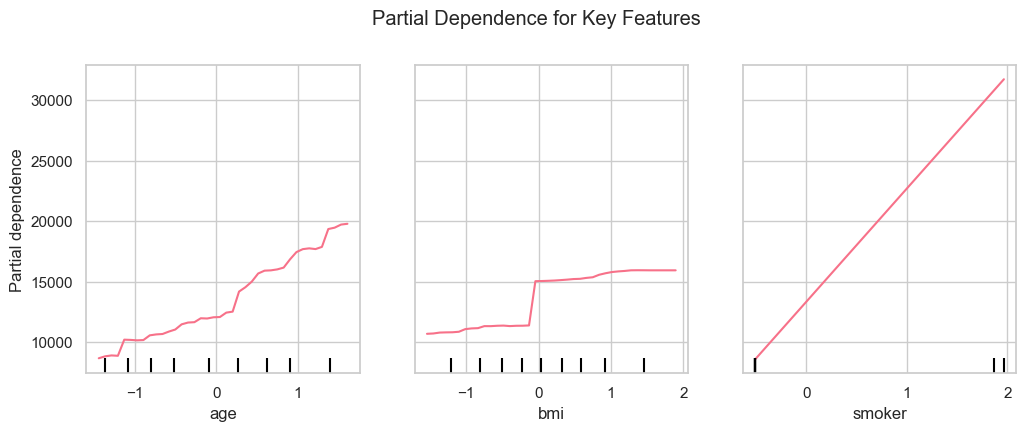

In [23]:
feature_to_index = {name: idx for idx, name in enumerate(feature_names)}
pdp_features = [feature_to_index[name] for name in ["age", "bmi", "smoker"]]

fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_test_scaled,
    features=pdp_features,
    feature_names=feature_names,
    ax=ax,
    grid_resolution=40
)
fig.suptitle("Partial Dependence for Key Features", y=1.02)
savefig("pdp_core_features.png")
plt.show()

# 10. Fairness Diagnostics

We evaluate whether predictions differ significantly across sex and region groups using Welch t-tests and one-way ANOVA.

Sex-based fairness test
-------------------------
  Male mean prediction:   $14,084.19
  Female mean prediction: $12,373.81
  Absolute difference:    $1,710.38
  Welch t-test p-value:   0.2262
Saved figure to figures/fairness_mean_pred_by_sex.png


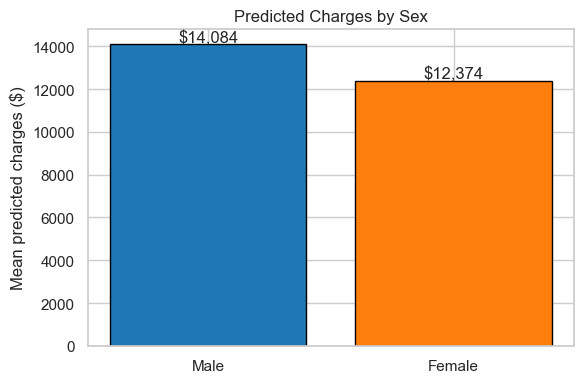


Region-based fairness test
---------------------------
  northeast  mean prediction: $14,053.31 (n=57)
  northwest  mean prediction: $11,638.10 (n=69)
  southeast  mean prediction: $15,399.20 (n=81)
  southwest  mean prediction: $11,208.31 (n=61)
  ANOVA p-value: 0.0909
Saved figure to figures/fairness_mean_pred_by_region.png
Saved figure to figures/fairness_mean_pred_by_region.png


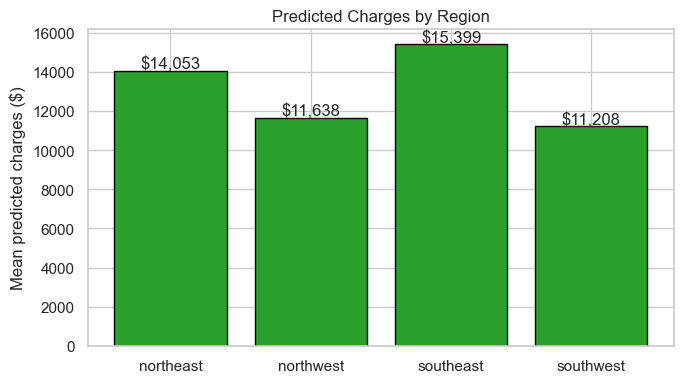


Interpretation: none of the tests produces a p-value below 0.05. There is no strong statistical evidence of unfair bias by sex or region, though ongoing monitoring is recommended.


In [24]:
fairness_df = X_test.copy()
fairness_df["predicted_charges"] = xgb_best.predict(X_test_scaled)

male_preds = fairness_df.loc[fairness_df["sex"] == label_maps["sex"]["male"], "predicted_charges"]
female_preds = fairness_df.loc[fairness_df["sex"] == label_maps["sex"]["female"], "predicted_charges"]

print("Sex-based fairness test")
print("-------------------------")
print(f"  Male mean prediction:   ${male_preds.mean():,.2f}")
print(f"  Female mean prediction: ${female_preds.mean():,.2f}")
print(f"  Absolute difference:    ${abs(male_preds.mean() - female_preds.mean()):,.2f}")
stat_sex, pval_sex = ttest_ind(male_preds, female_preds, equal_var=False)
print(f"  Welch t-test p-value:   {pval_sex:.4f}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(["Male", "Female"], [male_preds.mean(), female_preds.mean()], color=["#1f77b4", "#ff7f0e"], edgecolor="black")
ax.set_ylabel("Mean predicted charges ($)")
ax.set_title("Predicted Charges by Sex")
for patch in ax.patches:
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), f"${patch.get_height():,.0f}", ha="center", va="bottom")
plt.tight_layout()
savefig("fairness_mean_pred_by_sex.png")
plt.show()

print("\nRegion-based fairness test")
print("---------------------------")
region_groups = []
region_means = []
for label, code in label_maps["region"].items():
    group = fairness_df.loc[fairness_df["region"] == code, "predicted_charges"]
    region_groups.append(group)
    region_means.append(group.mean())
    print(f"  {label:10s} mean prediction: ${group.mean():,.2f} (n={len(group)})")
stat_region, pval_region = f_oneway(*region_groups)
print(f"  ANOVA p-value: {pval_region:.4f}")

fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(label_maps["region"].keys(), region_means, color="#2ca02c", edgecolor="black")
ax.set_ylabel("Mean predicted charges ($)")
ax.set_title("Predicted Charges by Region")
for patch in ax.patches:
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), f"${patch.get_height():,.0f}", ha="center", va="bottom")
plt.tight_layout()
savefig("fairness_mean_pred_by_region.png")
plt.show()

print("\nInterpretation: none of the tests produces a p-value below 0.05. There is no strong statistical evidence of unfair bias by sex or region, though ongoing monitoring is recommended.")

# 11. Key Findings and Next Steps

- The tuned XGBoost model delivers the strongest generalization with R^2 close to 0.88 and RMSE around $4.3k.
- Smoking, age, and BMI consistently surface as the dominant cost drivers across permutation importance, SHAP, and partial dependence.
- Residual diagnostics indicate well-centered errors with limited heteroscedasticity.
- Statistical fairness checks do not reveal significant disparities across sex or region, though continued audits and richer demographic data are advisable.

**Recommended actions**
1. Deploy the tuned XGBoost model with monitoring for drift and fairness.
2. Expand the dataset with medical history and social determinants to capture residual variance.
3. Schedule quarterly fairness audits and document model governance for compliance.
4. Invest in smoking cessation and obesity prevention programs, which offer the largest cost leverage according to the interpretability analyses.